# Combining Both The Text-Classification and ResNet50 Model for Cosine Similarity Scoring

In [ ]:
!unzip FIREWHEEL-master.zip

# Text Classification Portion

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

In [4]:
# Load the data
filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'data' )

dataframe1 = pd.read_csv(os.path.join(filepath, 'content2019-01-v3.tsv'), sep='\t')
dataframe1 = dataframe1.drop(columns=['article', 'aid', 'iid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'img', 'imgFile'])

dataframe2 = pd.read_csv(os.path.join(filepath, 'content2019-02-v3.tsv'), sep='\t')
dataframe2 = dataframe2.drop(columns=['article', 'aid', 'iid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'img', 'imgFile'])

dataframe3 = pd.read_csv(os.path.join(filepath, 'content2019-03-v3.tsv'), sep='\t')
dataframe3 = dataframe3.drop(columns=['article', 'aid', 'iid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'img', 'imgFile'])

# Combine the data into one dataframe
dataframe = pd.concat([dataframe1, dataframe2, dataframe3], ignore_index=True)

# Replace all the urls by their category
# Iterate all the rows
for index, row in dataframe.iterrows():
    
    # Split the 'url' by '/'
    list_of_splits = row['url'].split('/')
  
    # Traverse the splits, looking for 'www.ksta.de'
    for inner_index, word in enumerate(list_of_splits):
        
        # If the current word is the address...
        if word == 'www.ksta.de':

            # Replace row['url'] by what comes after (but remove the first occurrence of the '-' before doing so)
            row['url'] = list_of_splits[inner_index + 1].replace('-', '', 1).split('-')[0]
            break

# Rename the url column to 'target'
dataframe.rename(columns={'url': 'target'}, inplace=True)

# Combine the title and text data into one column
dataframe['textData'] = dataframe['title'] + ' ' + dataframe['text']
dataframe.drop(columns=['title', 'text'], inplace=True)

# Show some of the dataframe
dataframe

,target,textData
0,panorama,Mann wird durch Böller schwer an der Hand verl...
1,wirtschaft,Wie der Kölner Daniel Opoku sein altes Leben h...
2,wirtschaft,"„Wer auf Dauer im Beruf unglücklich ist, riski..."
3,panorama,Sydneys Feuerwerks-Meister unterläuft peinlich...
4,politik,Kim Jong Un droht mit Abkehr vom Annäherungsku...
...,...,...
7525,region,Neue Gruppen in Containern Die Stadt bemüht si...
7526,region,Fahrbahnsanierung der Bahnhofstraße beginnt Di...
7527,nrw,Schwebebahn startet nach Unfall wieder Testfah...
7528,wirtschaft,Kein Ende der Krise bei Bayer in Sicht Ein Urt...


In [5]:
# Get individual columns from the dataframe
target = dataframe['target']
textData = dataframe['textData']

# Create an encoder/decoder for 'target' categories
# Encoder
target_to_code = {}

# Decoder
code_to_target = {}

for index, row in enumerate(target.unique()):
    target_to_code[row] = index
    code_to_target[index] = row

# Map the target    
encoded_target = target.map(target_to_code)
print(encoded_target)

# Check encoding/decoding
print("encoded_target[1]:", encoded_target[1])
print("code_to_target[1]:", code_to_target[1])

0        0
1        1
2        1
3        0
4        2
        ..
7525     4
7526     4
7527    10
7528     1
7529     3
Name: target, Length: 7530, dtype: int64
encoded_target[1]: 1
code_to_target[1]: wirtschaft


In [6]:
# Vectorize the input data (and make a layer for it)

# Custom function to covert all letters to lowercase and remove punctuation
def custom_standardization(input_data):

  # Convert the input data to lowercase
  lowercase = tf.strings.lower(input_data)

  # Remove punctuation
  no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

  return no_punctuation

# Maximum number of tokens to work with
max_features = 10000

# Maximum sequence to analyze
sequence_length = 250

# Make the vectorization layer
vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length)

# 'Fit' the vectorization layer to index words
vectorize_layer.adapt(np.asarray(textData.astype(str)))

In [7]:
# Convert the training data into a tensor
train_textData = tf.convert_to_tensor(np.asarray(textData.astype(str)))

In [8]:
# Construct the model
embedding_dim = 16

# Instantiate the model with the various layers
text_classification_model = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(10000 + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(70)])

# Show a summary of the model
print(text_classification_model.summary())

# Compile the model
text_classification_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 16)           160016    
_________________________________________________________________
dropout (Dropout)            (None, 250, 16)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 70)                1190      
Total params: 161,206
Trainable params: 161,206
Non-trainable params: 0
__________________________________________________

In [9]:
# Number of epochs to use in the training of the model
epochs = 100

# Fit the model (takes about 5 minutes on Google Colab)
text_classification_model.fit(
    x=train_textData,
    y=encoded_target,
    epochs=epochs # 100 total
)

Epoch 1/100
236/236 [==============================] - 5s 8ms/step - loss: 3.4364 - accuracy: 0.3189
Epoch 2/100
236/236 [==============================] - 2s 8ms/step - loss: 2.1602 - accuracy: 0.3263
Epoch 3/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0661 - accuracy: 0.3263
Epoch 4/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0517 - accuracy: 0.3263
Epoch 5/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0459 - accuracy: 0.3263
Epoch 6/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0380 - accuracy: 0.3263
Epoch 7/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0396 - accuracy: 0.3263
Epoch 8/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0361 - accuracy: 0.3263
Epoch 9/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0330 - accuracy: 0.3263
Epoch 10/100
236/236 [==============================] - 2s 8ms/step - loss: 2.0328 - accura

In [ ]:
text_classification_model.save('/text_classification_model_TPU', save_format='tf')

INFO:tensorflow:Assets written to: /text_classification_model/assets


In [10]:
# Check that the model works with the testing data

# Get the directory path of the testing data
filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'data' )

# Load the testing data and drop the appropriate columns
testDataframe = pd.read_csv(os.path.join(filepath, 'MediaEvalNewsImagesBatch04articles.tsv'), sep='\t')
testDataframe = testDataframe.drop(columns=['Unnamed: 4', 'Unnamed: 3', 'articleID', 'url', 'aid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks'])

# Combine the title and text data into one column
testDataframe['textData'] = testDataframe['title'] + ' ' + testDataframe['text']
testDataframe.drop(columns=['title', 'text'], inplace=True)

# Check that the testing data looks as it should
testDataframe

# Covert the testing data into a tensor
testDataframe_tensor = tf.convert_to_tensor(np.asarray(testDataframe.astype(str)))

In [11]:
# Predict from the trained model
prediction = text_classification_model.predict(testDataframe_tensor[0])
print('pred:\n', prediction)

# Get the index of the maximum category
index_of_max_prediction = tf.argmax(prediction, axis=1)
print('ind:\n', index_of_max_prediction)

pred:
 [[ 4.66456     0.11148077  1.569925    1.2951677   0.7283055   2.5972145
  -4.142716    0.12528448  0.34255397 -1.5581056   1.1063657  -4.8214087
  -4.407771   -4.565612   -4.3368716  -4.252352   -4.176035   -4.554289
  -4.570456   -4.5268097  -4.554048   -4.3315153  -3.4176009  -4.2183595
  -4.429091   -4.1583457  -4.4368477  -4.2319717  -4.6364083  -4.5709796
  -4.351201   -4.4193115  -4.1378303  -4.215995   -4.5371733  -4.5869365
  -4.406113   -3.9738464  -4.3489184  -4.087402   -4.3144307  -4.292405
  -3.9475756  -4.1290393  -4.2610636  -4.6544366  -4.3999763  -4.148087
  -4.792323   -4.385519   -4.351776   -4.399864   -4.7461643  -4.262672
  -4.3418202  -4.197761   -4.1430187  -4.237104   -4.95713    -3.964203
  -4.1190224  -4.2376957  -4.7127028  -4.335073   -4.360735   -4.358054
  -4.603746   -4.30929    -3.08144    -4.453517  ]]
ind:
 tf.Tensor([0], shape=(1,), dtype=int64)


In [12]:
code_to_target[0]

'panorama'

In [13]:
def predict_text_and_title_category_from_text_classification_model(tensor_index):
    print(testDataframe.iloc[tensor_index])
    return text_classification_model.predict(testDataframe_tensor[tensor_index])

prediction = predict_text_and_title_category_from_text_classification_model(0)
print('pred:\n', prediction)

# Get the index of the maximum category
index_of_max_prediction = tf.argmax(prediction, axis=1)
print('ind:\n', index_of_max_prediction)

textData    Trainspotting-Star auf offener Straße erschoss...
Name: 0, dtype: object
pred:
 [[ 4.66456     0.11148077  1.569925    1.2951677   0.7283055   2.5972145
  -4.142716    0.12528448  0.34255397 -1.5581056   1.1063657  -4.8214087
  -4.407771   -4.565612   -4.3368716  -4.252352   -4.176035   -4.554289
  -4.570456   -4.5268097  -4.554048   -4.3315153  -3.4176009  -4.2183595
  -4.429091   -4.1583457  -4.4368477  -4.2319717  -4.6364083  -4.5709796
  -4.351201   -4.4193115  -4.1378303  -4.215995   -4.5371733  -4.5869365
  -4.406113   -3.9738464  -4.3489184  -4.087402   -4.3144307  -4.292405
  -3.9475756  -4.1290393  -4.2610636  -4.6544366  -4.3999763  -4.148087
  -4.792323   -4.385519   -4.351776   -4.399864   -4.7461643  -4.262672
  -4.3418202  -4.197761   -4.1430187  -4.237104   -4.95713    -3.964203
  -4.1190224  -4.2376957  -4.7127028  -4.335073   -4.360735   -4.358054
  -4.603746   -4.30929    -3.08144    -4.453517  ]]
ind:
 tf.Tensor([0], shape=(1,), dtype=int64)


# ResNet50 Categorization Portion


In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os

import tensorflow as tf
import tensorflow.keras as K

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import image, img_to_array
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

In [15]:
# Load the data
filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'data' )

dataframe1 = pd.read_csv(os.path.join(filepath, 'content2019-01-v3.tsv'), sep='\t')
dataframe1 = dataframe1.drop(columns=['article', 'aid', 'iid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'img', 'title', 'text'])

dataframe2 = pd.read_csv(os.path.join(filepath, 'content2019-02-v3.tsv'), sep='\t')
dataframe2 = dataframe2.drop(columns=['article', 'aid', 'iid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'img', 'title', 'text'])

dataframe3 = pd.read_csv(os.path.join(filepath, 'content2019-03-v3.tsv'), sep='\t')
dataframe3 = dataframe3.drop(columns=['article', 'aid', 'iid', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'img', 'title', 'text'])

# Combine the data into one dataframe
dataframe = pd.concat([dataframe1, dataframe2, dataframe3], ignore_index=True)

# Convert 'url' column to just the category
# Iterate all the rows
for index, row in dataframe.iterrows():
    
    # Split the 'url' by '/'
    list_of_splits = row['url'].split('/')
  
    # Traverse the splits, looking for 'www.ksta.de'
    for inner_index, word in enumerate(list_of_splits):
        if word == 'www.ksta.de':
            # Replace row['url'] by what comes after (but remove the first occurrence of the '-' before doing so)
            row['url'] = list_of_splits[inner_index + 1].replace('-', '', 1).split('-')[0]
            break

# Rename the url column to 'target'
dataframe.rename(columns={'url': 'target'}, inplace=True)

dataframe

,target,imgFile
0,panorama,31811446c816ac031a5a0b3add7d47a3813aec62rC.jpg
1,wirtschaft,3180830885ee043d58cd779d33cca388888e6b57vZ.jpg
2,wirtschaft,31808358806096e3c65a13dcfd59cde588e7eb0auc.jpg
3,panorama,31811494cf18c73a2fa30f16a949044c88b9beZx.jpg
4,politik,3181155429c50be85cf894763325d201ab241bc6oS.jpg
...,...,...
7525,region,322924547dc6683905a45c8456135b2d398e8edaKj.jpg
7526,region,32292576fc9b03f6d5c9c4cc9d0522832a760043Xj.jpg
7527,nrw,3228964244ba8985267cc39780cf4274488897a6IR.jpg
7528,wirtschaft,32292986c70c98472372d1ec08cad6ca7470a0eRT.jpg


In [16]:
# Load images from datasets
images_from_dataframes = []
images_not_found = 0

# For every row in the dataframe
for index, row in dataframe.iterrows():
    
    imageFound = False

    # Try loading an image from directory 1
    try: # From Directory '1'
        
        # Get the directory of the images
        filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'Pictures', 'Pictures', '1', row['imgFile'])

        # Load the image
        this_image = image.load_img(
            filepath,
            color_mode='rgb',
            target_size=(32, 32)
        )
        
        # Append the image to the list of images
        images_from_dataframes.append((this_image, row['imgFile'], row['target']))

        imageFound = True
        
    except:

        pass
    

    if not imageFound:
        # Try loading an image from directory 2
        try: # From Directory '1'
            
            # Get the directory of the images
            filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'Pictures', 'Pictures', '2', row['imgFile'])

            # Load the image
            this_image = image.load_img(
                filepath,
                color_mode='rgb',
                target_size=(32, 32)
            )
            
            # Append the image to the list of images
            images_from_dataframes.append((this_image, row['imgFile'], row['target']))
            
            imageFound = True

        except:

            pass

    if not imageFound:
        # Try loading an image from directory 3
        try: # From Directory '1'
            
            # Get the directory of the images
            filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'Pictures', 'Pictures', '3', row['imgFile'])

            # Load the image
            this_image = image.load_img(
                filepath,
                color_mode='rgb',
                target_size=(32, 32)
            )
            
            # Append the image to the list of images
            images_from_dataframes.append((this_image, row['imgFile'], row['target']))
            
            imageFound = True

        except:

            pass

# Make a new dataframe with the images
resnet_training_data = pd.DataFrame(data=images_from_dataframes, columns=['image', 'imgFile', 'target'])

resnet_training_images = resnet_training_data['image']
resnet_training_target = resnet_training_data['target']

In [17]:
# Construct the training set as ResNet50 expects it
resnet_training_images_input_tensor = []

for index, row in resnet_training_images.iteritems():
    resnet_training_images_input_tensor.append(tf.keras.utils.img_to_array(row))
    
resnet_training_images_input_tensor = np.asarray(resnet_training_images_input_tensor)

In [18]:
# Encode the target
resnet_training_encoded_target = []

for row in resnet_training_target:
    resnet_training_encoded_target.append(target_to_code.get(row))
    
resnet_training_encoded_target = K.utils.to_categorical(resnet_training_encoded_target, 70)

In [19]:
# Construct our model

# Construct the input layer
input_tensor = K.Input(shape=(32, 32, 3))

# Instantiate our model
resnet50_model = K.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Turn off the bulk of ResNet50 so that it remains unmodified
for layer in resnet50_model.layers[:143]:
    layer.trainable = False

# Build the NEW model
# Size to convert images to
to_res = (32, 32)

# Build the NEW model
retrained_resnet50_model = K.models.Sequential()

# Add an input layer
retrained_resnet50_model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))

# Add the ResNet50 model!
retrained_resnet50_model.add(resnet50_model)

# Add layers that lead to the end
retrained_resnet50_model.add(K.layers.Flatten())
retrained_resnet50_model.add(K.layers.BatchNormalization())
retrained_resnet50_model.add(K.layers.Dense(256, activation='relu'))
retrained_resnet50_model.add(K.layers.Dropout(0.5))
retrained_resnet50_model.add(K.layers.BatchNormalization())
retrained_resnet50_model.add(K.layers.Dense(128, activation='relu'))
retrained_resnet50_model.add(K.layers.Dropout(0.5))
retrained_resnet50_model.add(K.layers.BatchNormalization())
retrained_resnet50_model.add(K.layers.Dense(70, activation='softmax')) # Final encoded output layer

# Check the progress of the training
check_point = K.callbacks.ModelCheckpoint(filepath='imagenet_firewheel.h5',
                                          monitor='val_acc',
                                          mode='max',
                                          save_best_only=True)

# Compile the model
retrained_resnet50_model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])


94781440/94765736 [==============================] - 1s 0us/step


In [20]:
# Fit the model (takes about 45 minutes on Google Colab)
retrained_resnet50_model.fit(
    x=resnet_training_images_input_tensor,
    y=resnet_training_encoded_target,
    batch_size=32,
    epochs = 10,
    callbacks=[check_point]
)

Epoch 1/10
233/233 [==============================] - 50s 63ms/step - loss: 4.8448 - accuracy: 0.0157
Epoch 2/10
233/233 [==============================] - 14s 61ms/step - loss: 4.7404 - accuracy: 0.0201
Epoch 3/10
233/233 [==============================] - 14s 60ms/step - loss: 4.6788 - accuracy: 0.0227
Epoch 4/10
233/233 [==============================] - 14s 61ms/step - loss: 4.5814 - accuracy: 0.0308
Epoch 5/10
233/233 [==============================] - 14s 60ms/step - loss: 4.4994 - accuracy: 0.0409
Epoch 6/10
233/233 [==============================] - 14s 60ms/step - loss: 4.4192 - accuracy: 0.0524
Epoch 7/10
233/233 [==============================] - 14s 60ms/step - loss: 4.3151 - accuracy: 0.0674
Epoch 8/10
233/233 [==============================] - 14s 60ms/step - loss: 4.2215 - accuracy: 0.0871
Epoch 9/10
233/233 [==============================] - 14s 60ms/step - loss: 4.1358 - accuracy: 0.1074
Epoch 10/10
233/233 [==============================] - 14s 61ms/step - loss: 4.055

In [ ]:
!mkdir model

In [ ]:
retrained_resnet50_model.save('/model', save_format='tf')

INFO:tensorflow:Assets written to: /model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
# Function to predict from model
def predict_image_category_from_custom_resnet50_model(path_to_file):
    x = image.load_img(path_to_file, target_size=(32, 32))
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return retrained_resnet50_model.predict(x)

# Get a sample image prediction
image_filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'Pictures', 'Pictures', '4', '2-84315333-highres.jpg')

prediction = predict_image_category_from_custom_resnet50_model(image_filepath)
print('pred:\n', prediction)

# Get the index of the maximum category
index_of_max_prediction = tf.argmax(prediction, axis=1)
print('ind:\n', index_of_max_prediction)


pred:
 [[0.03455659 0.00962323 0.01030116 0.01887261 0.02183663 0.02032502
  0.01574032 0.01101292 0.03705924 0.02099603 0.01969961 0.02133606
  0.00421069 0.01493765 0.00887161 0.00977669 0.02944573 0.0050054
  0.01985176 0.01045396 0.01265098 0.00463081 0.00916388 0.03160807
  0.0071906  0.01007057 0.01271445 0.00847025 0.0231418  0.00562715
  0.03525976 0.01316929 0.00408072 0.00605692 0.02060071 0.01427857
  0.02071609 0.02012273 0.01630792 0.01288343 0.01008812 0.01923787
  0.01115823 0.01278549 0.01054589 0.01520003 0.00744766 0.00816479
  0.00959496 0.01295837 0.00813894 0.01300663 0.01026664 0.01031832
  0.01041697 0.02135332 0.03643548 0.00609641 0.01041655 0.01613805
  0.00571893 0.01328929 0.0069871  0.01095509 0.00895915 0.01385377
  0.0089976  0.0242234  0.00589661 0.00869275]]
ind:
 tf.Tensor([8], shape=(1,), dtype=int64)


In [22]:
code_to_target[3]

'koeln'

# Combining Title/Text Classification and Image Categorization Models with Cosine Similarity Scoring

## Image Prediction

In [23]:
# Load all images from the test data
image_directory = os.path.join(os.getcwd(),'FIREWHEEL-master', 'Pictures', 'Pictures', '4')

# List to hold all images, their filenames, and their predictions
all_images_and_their_predictions = []

# Iterate over every image
for current_image in os.listdir(image_directory):
    
    # Construct the full path of the image
    full_path = os.path.join(image_directory, current_image)
    
    # Append to the list the...
    all_images_and_their_predictions.append(
        (
            current_image, # ... filename
            image.load_img(full_path), # ... the image itself
            predict_image_category_from_custom_resnet50_model(full_path) # ...and the prediction
        )
    )

In [24]:
# See what some of it looks like
all_images_and_their_predictions[0]

('enrique-iglesias-dpa.jpg',
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x150 at 0x7FD1DE6DD710>,
 array([[0.01742882, 0.01792908, 0.02714306, 0.01030368, 0.00625574,
         0.02401019, 0.01852323, 0.02536107, 0.00961238, 0.01187101,
         0.02975018, 0.01518169, 0.00907237, 0.01587668, 0.00631885,
         0.01122189, 0.03397872, 0.0048692 , 0.01590563, 0.01265182,
         0.01153506, 0.00564616, 0.01477617, 0.00961818, 0.01442229,
         0.00962864, 0.00939959, 0.01739679, 0.0099417 , 0.02078647,
         0.01248621, 0.01450507, 0.00423805, 0.0093092 , 0.004351  ,
         0.00819779, 0.03081368, 0.01461032, 0.01753346, 0.0052724 ,
         0.01316177, 0.01953398, 0.01532231, 0.02281186, 0.00979801,
         0.01650102, 0.01580591, 0.01549624, 0.02235479, 0.01606088,
         0.00953517, 0.01321972, 0.00936146, 0.00548413, 0.02882421,
         0.02403749, 0.011379  , 0.00504651, 0.01419804, 0.01148352,
         0.00998964, 0.00979473, 0.01595658, 0.00726375, 0.

In [ ]:
# Write the image predictions out to a file
with open('dataset_4_image_category_predictions.csv', 'w') as f:
    f.write('imageName, prediction\n')

    for name, _, prediction in all_images_and_their_predictions:
        f.write(name)
        f.write(', ')
        f.write(str(prediction).replace('\n', ''))
        f.write('\n')

# Title/Text Prediction

In [25]:
# Redefine image prediction to return tuple
def predict_text_and_title_category_from_text_classification_model(tensor_index):
    return (custom_standardization(testDataframe.iloc[tensor_index]['textData']).numpy().decode('UTF-8'), text_classification_model.predict(testDataframe_tensor[tensor_index]))

# Test function
predict_text_and_title_category_from_text_classification_model(1914)

('„kohlekraftwerke haben keinen platz in zukunfststrategie mehr“ der energiekonzern rwe hat die planungen zum bau des neuen braunkohlekraftwerks boaplus am standort niederaußem eingestellt dies gab das unternehmen am freitagmorgen bekannt „das vorhaben war eine option um bestehende kraftwerke durch eine neue anlage',
 array([[ 0.02957481, -0.01164114,  0.5377928 ,  3.2740164 ,  5.953232  ,
         -0.03509229, -4.2835226 ,  0.01098431, -1.3354447 , -1.5901552 ,
          1.1114221 , -4.37766   , -4.841778  , -4.846684  , -4.52162   ,
         -4.8395934 , -4.6292667 , -5.01795   , -4.747758  , -5.1757374 ,
         -5.0864754 , -5.097746  , -2.9186878 , -4.7516494 , -4.4451923 ,
         -4.502508  , -5.0206985 , -4.686153  , -5.19673   , -4.6540174 ,
         -4.5984764 , -4.4938745 , -4.7347527 , -4.7515817 , -4.4991903 ,
         -4.3902626 , -4.356159  , -4.7123194 , -4.671808  , -4.4171886 ,
         -4.529266  , -4.838463  , -4.3714924 , -4.477742  , -4.956408  ,
         -4.472

In [26]:
# Make a list containing the title/text and its prediction
all_title_text_and_their_predictions = []

for index in range(len(testDataframe) - 1):
    this_text, this_prediction = predict_text_and_title_category_from_text_classification_model(index)
    all_title_text_and_their_predictions.append((this_text, this_prediction))

In [ ]:
# Write the title/text predictions out to a file
with open('dataset_4_title_text_predictions.csv', 'w') as f:
    f.write('title_text, prediction\n')

    for text, prediction in all_title_text_and_their_predictions:
        f.write(text)
        f.write(',')
        f.write(str(prediction).replace('\n', ''))
        f.write('\n')

# Cosine Similarity Scoring

In [27]:
# See an example of an image and its prediction
TITLE = 0
IMAGE = 1
PREDICTION = 2

all_images_and_their_predictions[0][TITLE]

'enrique-iglesias-dpa.jpg'

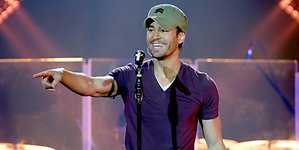

In [28]:
all_images_and_their_predictions[0][IMAGE]

In [29]:
all_images_and_their_predictions[0][PREDICTION]

array([[0.01742882, 0.01792908, 0.02714306, 0.01030368, 0.00625574,
        0.02401019, 0.01852323, 0.02536107, 0.00961238, 0.01187101,
        0.02975018, 0.01518169, 0.00907237, 0.01587668, 0.00631885,
        0.01122189, 0.03397872, 0.0048692 , 0.01590563, 0.01265182,
        0.01153506, 0.00564616, 0.01477617, 0.00961818, 0.01442229,
        0.00962864, 0.00939959, 0.01739679, 0.0099417 , 0.02078647,
        0.01248621, 0.01450507, 0.00423805, 0.0093092 , 0.004351  ,
        0.00819779, 0.03081368, 0.01461032, 0.01753346, 0.0052724 ,
        0.01316177, 0.01953398, 0.01532231, 0.02281186, 0.00979801,
        0.01650102, 0.01580591, 0.01549624, 0.02235479, 0.01606088,
        0.00953517, 0.01321972, 0.00936146, 0.00548413, 0.02882421,
        0.02403749, 0.011379  , 0.00504651, 0.01419804, 0.01148352,
        0.00998964, 0.00979473, 0.01595658, 0.00726375, 0.0127213 ,
        0.01405818, 0.01167881, 0.01479535, 0.01627379, 0.02031836]],
      dtype=float32)

In [30]:
# See an example of the title/text and its prediction
TITLE_TEXT = 0
TITLE_TEXT_PREDICTION = 1

all_title_text_and_their_predictions[0][TITLE_TEXT]

'trainspottingstar auf offener straße erschossen in schottland haben unbekannte den schauspieler bradley welsh erschossen wie britische medien berichten wurde der 42jährige in der nähe seines hauses in der stadt edinburgh getötet welch der auch als boxer karriere gemacht hatte wurde durch den film'

In [31]:
all_title_text_and_their_predictions[0][TITLE_TEXT_PREDICTION]

array([[ 4.66456   ,  0.11148077,  1.569925  ,  1.2951677 ,  0.7283055 ,
         2.5972145 , -4.142716  ,  0.12528448,  0.34255397, -1.5581056 ,
         1.1063657 , -4.8214087 , -4.407771  , -4.565612  , -4.3368716 ,
        -4.252352  , -4.176035  , -4.554289  , -4.570456  , -4.5268097 ,
        -4.554048  , -4.3315153 , -3.4176009 , -4.2183595 , -4.429091  ,
        -4.1583457 , -4.4368477 , -4.2319717 , -4.6364083 , -4.5709796 ,
        -4.351201  , -4.4193115 , -4.1378303 , -4.215995  , -4.5371733 ,
        -4.5869365 , -4.406113  , -3.9738464 , -4.3489184 , -4.087402  ,
        -4.3144307 , -4.292405  , -3.9475756 , -4.1290393 , -4.2610636 ,
        -4.6544366 , -4.3999763 , -4.148087  , -4.792323  , -4.385519  ,
        -4.351776  , -4.399864  , -4.7461643 , -4.262672  , -4.3418202 ,
        -4.197761  , -4.1430187 , -4.237104  , -4.95713   , -3.964203  ,
        -4.1190224 , -4.2376957 , -4.7127028 , -4.335073  , -4.360735  ,
        -4.358054  , -4.603746  , -4.30929   , -3.0

In [32]:
# Import Library
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
# Compare between the first title/text and the first image
cosine_similarity(all_title_text_and_their_predictions[0][TITLE_TEXT_PREDICTION], all_images_and_their_predictions[0][PREDICTION])

array([[-0.7381997]], dtype=float32)

In [34]:
# Compare between the first title/text and the second image
cosine_similarity(all_title_text_and_their_predictions[0][TITLE_TEXT_PREDICTION], all_images_and_their_predictions[1][PREDICTION])

array([[-0.65784216]], dtype=float32)

In [35]:
# Compare between the first title/text and the third image
cosine_similarity(all_title_text_and_their_predictions[0][TITLE_TEXT_PREDICTION], all_images_and_their_predictions[2][PREDICTION])

array([[-0.64320767]], dtype=float32)

In [36]:
# List to store results
results = []

# Iterate over all the title/text entries
for index_title, title_text_pred in enumerate(all_title_text_and_their_predictions):

    # # List to hold the top_100 image matchings
    # top_100 = []

    # # Find the cosine similarites between the current title/text and all the entries
    # for index_image, img_pred in enumerate(all_images_and_their_predictions):
    #     similarity = abs(cosine_similarity(title_text_pred[TITLE_TEXT_PREDICTION], img_pred[PREDICTION]))
    #     top_100.append((img_pred, similarity))

    # # Sort the list by similary
    # top_100.sort(key=lambda x:x[1], reverse=True)

    # # Only get the top 100
    # top_100 = top_100[:100]

    # # Append it to the final results
    # results.append((title_text_pred, top_100))

    # **************************************************************************************************************

    # List to hold all image matchings
    all = []

    # Find the cosine similarites between the current title/text and all the entries
    for index_image, img_pred in enumerate(all_images_and_their_predictions):
        similarity = abs(cosine_similarity(title_text_pred[TITLE_TEXT_PREDICTION], img_pred[PREDICTION]))
        all.append((img_pred, similarity))

    # Sort the list by similary
    all.sort(key=lambda x:x[1], reverse=True)

    # Append it to the final results
    results.append((title_text_pred, all))

# Results Structure

In [ ]:
# results[0][0] - Tuple containing (text, text-prediction)

# results[0][1] - list of sorted top 100 images' tuple ((image-name, image, image-prediction), cosine-similarity to text)
# results[0][1] - list of sorted all images' tuple ((image-name, image, image-prediction), cosine-similarity to text)

# results[0][1][0][0] - Tuple of (name, image, prediction)
# results[0][1][0][1] - cosine similarity

# results[0] - First result
# results[0][0] - That first result's text and text-prediction
# results[0][1] - That first result's list of top 100 matching images
# results[0][1][0] - That first result's top matching image tuple ((image-name, image, image-prediction), cosine-similarity)
# results[0][1][0][0][0] - That first result's top matching image-name
# results[0][1][0][0][1] - That first result's top matching image
# results[0][1][0][0][2] - That first result's top matching image-prediction array
# results[0][1][0][1] - That first result's top matching image's cosine similarity

array([[0.8182955]], dtype=float32)

In [ ]:
# Write the results out to a file
with open('all_results_Text_and_Image_Name.csv', 'w') as f:
   
    for result in results:

      # Write the text to match
      f.write(result[0][0])
      f.write('\n')

      for index, matching_image_tuple in enumerate(result[1]):

          # Write the position of the match
          f.write(str(index + 1))
          f.write(', ')

          # Write the top image's cosine similarity
          f.write(str(matching_image_tuple[1]))
          f.write(', ')

          # Write the top image's name
          f.write(matching_image_tuple[0][0])
          f.write('\n')
      
      f.write('\n\n')

In [37]:
# Convert to Article ID and rank by Image ID

# Get article data

# Get the directory path of the testing data
filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'data' )

# Load the testing data and drop the appropriate columns
testDataframe = pd.read_csv(os.path.join(filepath, 'MediaEvalNewsImagesBatch04articles.tsv'), sep='\t')
testDataframe = testDataframe.drop(columns=['Unnamed: 4', 'Unnamed: 3', 'url', 'hashvalue', 'nImpressions', 'nRecs', 'nClicks', 'aid'])

testDataframe = testDataframe.drop(1915)

# Check that the testing data looks as it should
testDataframe

,articleID,title,text
0,1.000265e+09,Trainspotting-Star auf offener Straße erschossen,In Schottland haben Unbekannte den Schauspiele...
1,1.001935e+09,S-Bahn-Gleis am Kölner Hauptbahnhof ist gesperrt,Der S-Bahn-Bahnsteig am Kölner Hauptbahnhof is...
2,1.002375e+09,Drogendealer in Mülheim auf frischer Tat ertappt,Die Polizei hat einen einen 22-jährigen Drogen...
3,1.002735e+09,Die ungewöhnliche Ostermesse auf dem Autoscooter,"Mit fast 33 Metern Höhe, einer Streckenlänge v..."
4,1.002835e+09,Polizei fasst flüchtende Einbrecher nach 40 Se...,Das war ein kurzer Ausflug für zwei Einbrecher...
...,...,...,...
1910,1.999075e+09,Bücher schreiben ist eben auch ein Bürojob,Nach mehr als 30 Jahren Funkstille taucht Hora...
1911,1.999165e+09,RB Leipzig gewinnt dramatischen Pokalfight in ...,RB Leipzig darf dank Marcel Halstenberg weiter...
1912,1.999345e+09,Berliner Eisbärchen heißt Hertha,Begeisterung für Bälle hat sie schon gezeigt: ...
1913,1.999355e+09,Bund zahlt 600.000 Euro Schadensersatz,Für Schäden nach einem Moorbrand auf dem Gelän...


In [38]:
# Convert to Article ID and rank by Image ID

# Get image data

# Get the directory path of the testing data
filepath = os.path.join(os.getcwd(),'FIREWHEEL-master', 'data' )

# Load the testing data and drop the appropriate columns
imagesDataframe = pd.read_csv(os.path.join(filepath, 'MediaEvalNewsImagesBatch04images.tsv'), sep='\t')
imagesDataframe = imagesDataframe.drop(columns=['imgFile'])
imagesDataframe = imagesDataframe.rename(columns={'img': 'filename'})
imagesDataframe = imagesDataframe.drop(1915)

image_filename_and_id = []

# Replace the filename column with the last split
for row in imagesDataframe.iterrows():
    image_filename_and_id.append((row[1][0].split('/')[-1], int(row[1][1])))

image_filename_and_id = pd.DataFrame(data=image_filename_and_id, columns=['filename', 'id'])
image_filename_and_id

,filename,id
0,spannende-galopprennen.jpg,134801
1,dpa-halt-polizei-schild.jpg,136751
2,dpa-zuguebergang-andreaskreuz.jpg,135527
3,dpa-bahn-faehrt-in-bahnhof.jpg,135908
4,britta-havlicek-haltestelle-bus.jpg,135583
...,...,...
1910,kelly-maite-26042019-27--1-.jpg,136927
1911,bayern-jubel-gegen-bremen.jpg,136928
1912,20190302bucco-007.jpg,136931
1913,feuer-ruenderoth.jpg,136958


In [39]:
# Custom function to covert all letters to lowercase and remove punctuation
def custom_standardization(input_data):

    # Convert the input data to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove punctuation
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

    return no_punctuation.numpy().decode("utf-8")

In [65]:
# results[0][0] - Tuple containing (text, text-prediction)

# results[0][1] - list of sorted top 100 images' tuple ((image-name, image, image-prediction), cosine-similarity to text)
# results[0][1] - list of sorted all images' tuple ((image-name, image, image-prediction), cosine-similarity to text)

# results[0][1][0][0] - Tuple of (name, image, prediction)
# results[0][1][0][1] - cosine similarity

# results[0] - First result
# results[0][0] - That first result's text and text-prediction
# results[0][1] - That first result's list of top 100 matching images
# results[0][1][0] - That first result's top matching image tuple ((image-name, image, image-prediction), cosine-similarity)
# results[0][1][0][0][0] - That first result's top matching image-name
# results[0][1][0][0][1] - That first result's top matching image
# results[0][1][0][0][2] - That first result's top matching image-prediction array
# results[0][1][0][1] - That first result's top matching image's cosine similarity

# Make a new list
results_by_id = []

# memoiazation
images_dictionary = {}

# Iterate over all the results
for result in results:

    current_article_id = None

    # Find the article ID of the text row
    for row in testDataframe.iterrows():
        try:
            if result[0][0].startswith(custom_standardization(row[1][1])):
                current_article_id = int(row[1][0])
                break
        except:
            pass

    # If an article Id was found, do the thing
    if current_article_id is not None:
        
        # Make a list to hold all sorted image IDs
        list_of_image_ids = []

        # Iterate over the entire list of sorted images
        for image_to_find in result[1]:

            # Get it from the dictionary
            image_to_add_to_the_list = images_dictionary.get(image_to_find[0][0])

            # If it was not found in the dictionary
            if image_to_add_to_the_list is None:

              # Find the image ID of the image name
              for other_row in image_filename_and_id.iterrows():

                  # Add it to the dictionary!
                  if image_to_find[0][0] == other_row[1][0]:
                      images_dictionary[image_to_find[0][0]] = other_row[1][1]
                      break
            
            # Get it from the dictionary again (it should have been found)
            image_to_add_to_the_list = images_dictionary.get(image_to_find[0][0])
            
            # Add it to the list
            if image_to_add_to_the_list is not None:
                list_of_image_ids.append((image_to_add_to_the_list, image_to_find[1]))

        results_by_id.append((current_article_id, list_of_image_ids))

In [67]:
# results_by_id[0] - First element of results: tuple (articleID, [sorted list of imageIDs that mostly likely match, but its a tuple of (imageID, Cosine similarity)])

# results_by_id[0][0] - article ID
# results_by_id[0][1] - List of matching images
# results_by_id[0][1][0] - Top matching image tuple
# results_by_id[0][1][0][0] - imageID
# results_by_id[0][1][0][1][0][0] - cosign similarity

results_by_id[0][1]

1000265260

In [76]:
# Write all the results to a file
with open('all_results_by_articleID_and_imageID.csv', 'w') as f:

    f.write('articleID, imageIDs in order by most-likely matching (cosine similarity)\n')

    for final_result in results_by_id:
        f.write(str(final_result[0]))
        f.write(', ')
        for each_image_id in final_result[1]:
            f.write(str(each_image_id[0]))
            f.write(' (')
            f.write(str(each_image_id[1][0][0]))
            f.write('), ')
        f.write('\n')